In [2]:
import os
import keras
import numpy as np
from tqdm import tqdm 
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array 
import matplotlib.pyplot as plt

# Load Data

data ---
https://www.kaggle.com/code/utkarshsaxenadn/pix2pixgan-map-generator/notebook

In [3]:
def load_data(path, trim=None):
  paths = sorted(glob(path + "*.jpg"))
  set = path.split('\\')[1]
    
  if trim is not None:
    paths = sorted(glob(path + "*.jpg"))[:trim]
      
  images = np.zeros(shape=(len(paths), 256, 256, 3))
  masks = np.zeros(shape=(len(paths), 256, 256, 3))
    
  for i,path in tqdm(enumerate(paths), desc="Data"):
    image = tf.cast(img_to_array(load_img(path)), tf.float32)
    # adjust for different size inputs
    if (set == 'maps'):
      img = image[:,:600,:]
      mask = image[:,600:,:]
    elif (set == 'facades'):
      img = image[:,:256,:]
      mask = image[:,256:,:]

    images[i] = tfi.resize(img,(256,256))/255.
    masks[i] = tfi.resize(mask,(256,256))/255.

  if (set == 'facades'):
    images, masks = np.copy(masks), np.copy(images)
  
  return images, masks

def show_image(image, title=None, alpha=1.0):
  plt.imshow(image, alpha=alpha)
  if title is not None:
    plt.title(title)
  plt.axis("off")

def show_mask(image, mask, alpha=0.4, title=None):
  image = tf.squeeze(tf.cast(image, tf.float32))
  mask = tf.squeeze(tf.cast(mask, tf.float32))
  show_image(image)
  show_image(mask, alpha=alpha, title=title)
  
# def load_data(path, trim=None):
#   paths = sorted(glob(path + "*.jpg"))
    
#   if trim is not None:
#     paths = sorted(glob(path + "*.jpg"))[:trim]
      
#   images = np.zeros(shape=(len(paths), 256, 256, 3))
#   masks = np.zeros(shape=(len(paths), 256, 256, 3))
    
#   for i,path in tqdm(enumerate(paths), desc="Data"):
#       image = tf.cast(img_to_array(load_img(path)), tf.float32)
#       img = image[:,:600,:]
#       mask = image[:,600:,:]
#       images[i] = tfi.resize(img,(256,256))/255.
#       masks[i] = tfi.resize(mask,(256,256))/255.
#   return images, masks


In [7]:
dataset = load_data('Data\\maps\\train\\', trim=3000,)
images, masks = dataset

Data: 1096it [00:19, 55.63it/s]


In [8]:
# preprocess image data
def preprocess(input_image, target_image):
  input_image = tf.image.resize(input_image, [256, 256])
  target_image = tf.image.resize(target_image, [256, 256])
  return input_image, target_image


data = (
    tf.data.Dataset.from_tensor_slices((images, masks))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


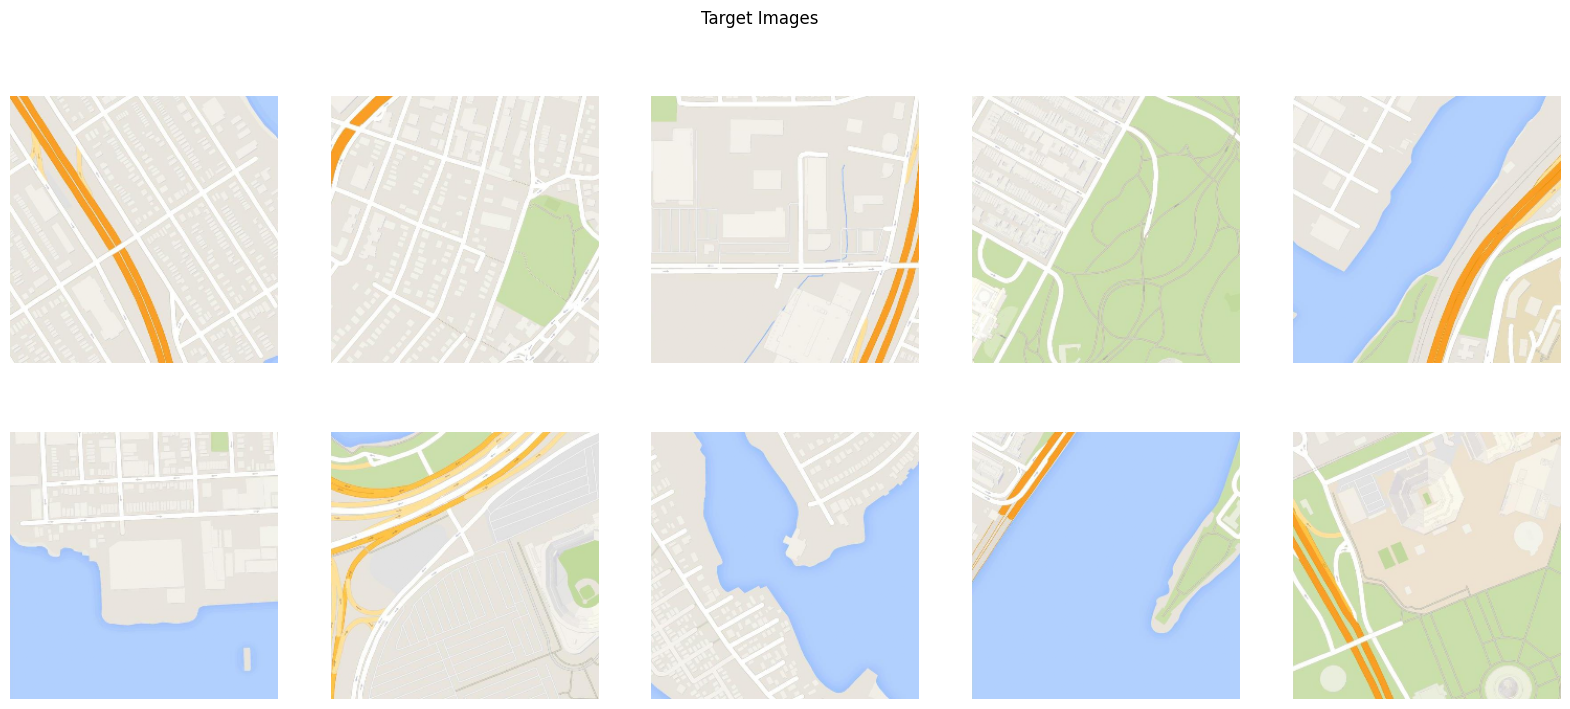

In [9]:
for images, masks in data.take(1):
    sample_images = images
    sample_masks = masks
    break

plt.figure(figsize=(20,8))
plt.suptitle('Target Images')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_image(sample_masks[i])

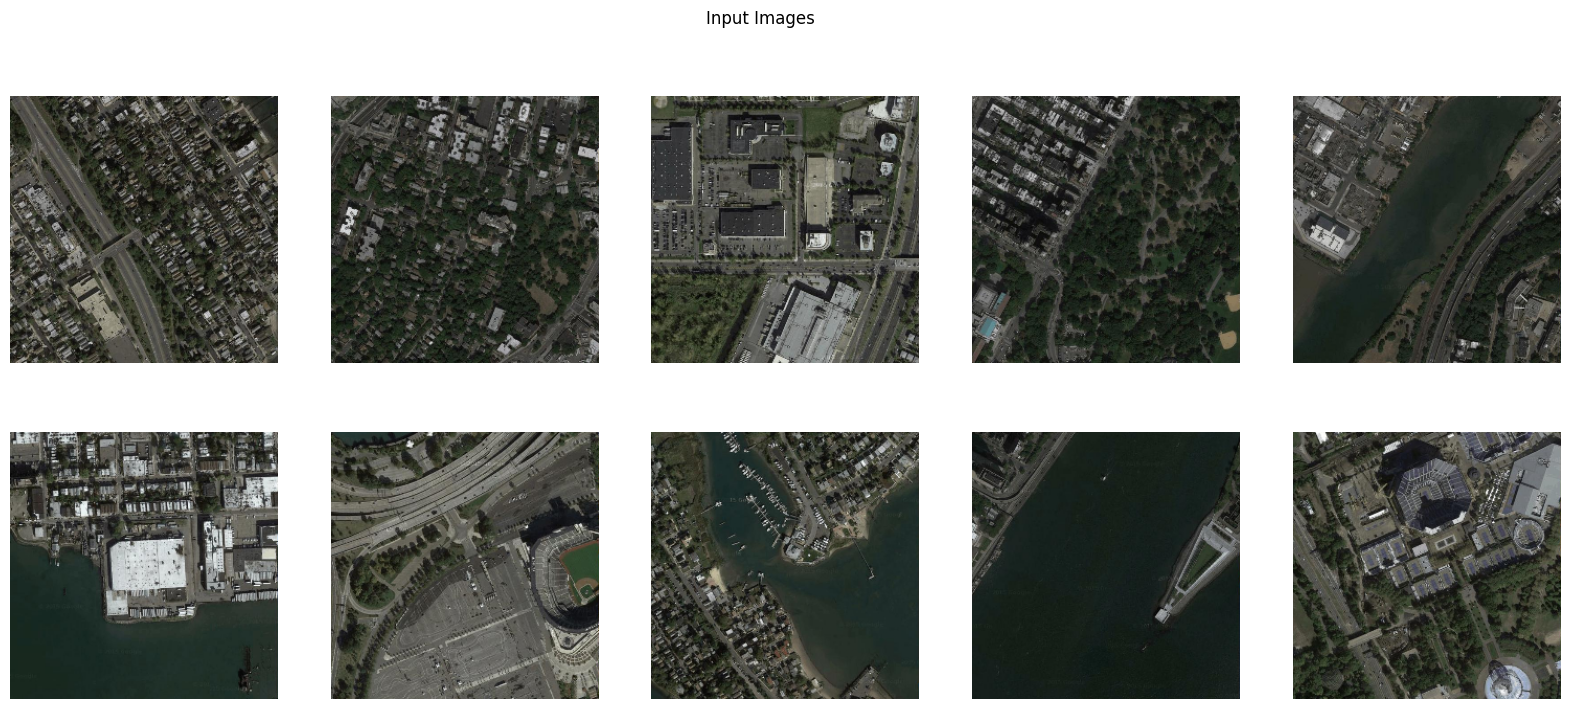

In [10]:
plt.figure(figsize=(20,8))
plt.suptitle('Input Images')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_image(sample_images[i])

# Upsample and Downsample functions

In [ ]:
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.layers import Conv2DTranspose

from keras.initializers import RandomNormal
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model, load_model

from tensorflow.keras.utils import plot_model

from keras.losses import BinaryCrossentropy

def downsample(filters, size, batch_norm=True):
    
  layer = Sequential()
  layer.add(Conv2D(filters, kernel_size=size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
  if batch_norm:
      layer.add(BatchNormalization())
  layer.add(LeakyReLU())
  
  return layer

def upsample(filters, size, dropout=False):
  layer = Sequential()
  layer.add(Conv2DTranspose(filters, kernel_size=size, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
  layer.add(BatchNormalization())
  if dropout:
      layer.add(Dropout(0.5))
  layer.add(ReLU())
  return layer


# Create the Generator
## The generator is a series of upsampling and downsampling (Encoder/Decoder)<br>
The generator begins by encoding the input image (downsampling while increeasing the number of filters)<br>
the it will decode by upsampling increasing the resolution with the new style in mind<br>
Then it goes through one final layer which is a transposed convolutional layer with 3 filters to output and RGB image<br>

In [ ]:
class Generator:
  def __init__(self):
    inputs = Input(shape=(256, 256, 3))
    downsample_stack = [
      downsample(64, 4, batch_norm=False),
      downsample(128, 4), 
      downsample(256, 4), 
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4)]
    
    upsample_stack=[
      upsample(512, 4,dropout=True), # dropout used to for regularization
      upsample(512, 4,dropout=True),
      upsample(512, 4,dropout=True),
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
      ]
  
    last = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh', kernel_initializer=tf.random_normal_initializer(0.,0.02))

    # skip connections are important to emphasize finer detail features
    x = inputs
    skips = []
    for down in downsample_stack: 
      x = down(x)
      skips.append(x)
    
    skips = reversed(skips[:-1]) # reverse skip connection and remove bottle neck
    # add downsample skip connections to the up sample stack
    for up, skip, in zip(upsample_stack, skips):
      x = up(x)
      x = concatenate([x, skip])
    
    x = last(x)
    self.model = Model(inputs=inputs, outputs=x)

In [13]:
generator = Generator()
generator.model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

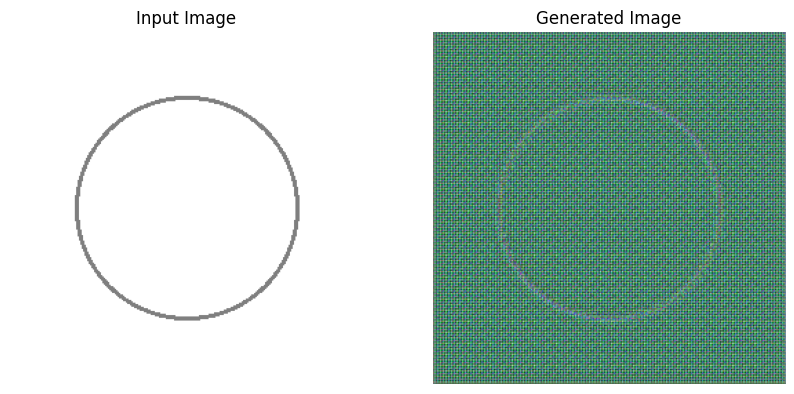

In [ ]:
test_input = np.ones((256, 256, 3), dtype=np.float32)

center = (128, 128)
radius = 80
color = (0, 0, 0)
for y in range(256):
    for x in range(256):
        if abs(np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2) - radius) < 1.5:
            test_input[y, x] = color
test_input = tf.expand_dims(test_input, axis=0)

generated_image = generator.model(test_input, training=False)

# # Remove the batch dimension and normalize values to [0, 1]
test_input = (test_input[0] + 1) / 2  # Normalizing from [-1, 1] to [0, 1]
generated_image = (generated_image[0] + 1) / 2  # Normalizing from [-1, 1] to [0, 1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(test_input.numpy())
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_image.numpy())
plt.axis("off")

plt.show()

# Create Discriminator
Distinguish between real and fake images<br>
used with the generator to increase the generators performance and creating realistic fake images<br>
The discriminator outputs a grid of scored where each score represents the "realness" of a patch

In [ ]:
class Discriminator:
  def __init__(self):
    init = tf.random_normal_initializer(0.,0.02)
    input = Input(shape=(256,256,3), name="input_image")
    target = Input(shape=(256,256,3), name="target)image")

    x = concatenate([input, target]) # concatonate both the target and the input so the discriminator can anaylze both at the same time

    x = downsample(64, 4, batch_norm=False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    
    x = ZeroPadding2D()(x)  # add padding
    #  intermedtiate convolution for assessing the patterns in both images
    x = Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = ZeroPadding2D()(x) # remove padding
    
    x = Conv2D(1, 4, kernel_initializer=init)(x)
    self.model = Model(inputs=[input, target], outputs=[x])


In [16]:
discriminator = Discriminator()
discriminator.model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target)image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target)image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      6,144 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

Testing discriminator

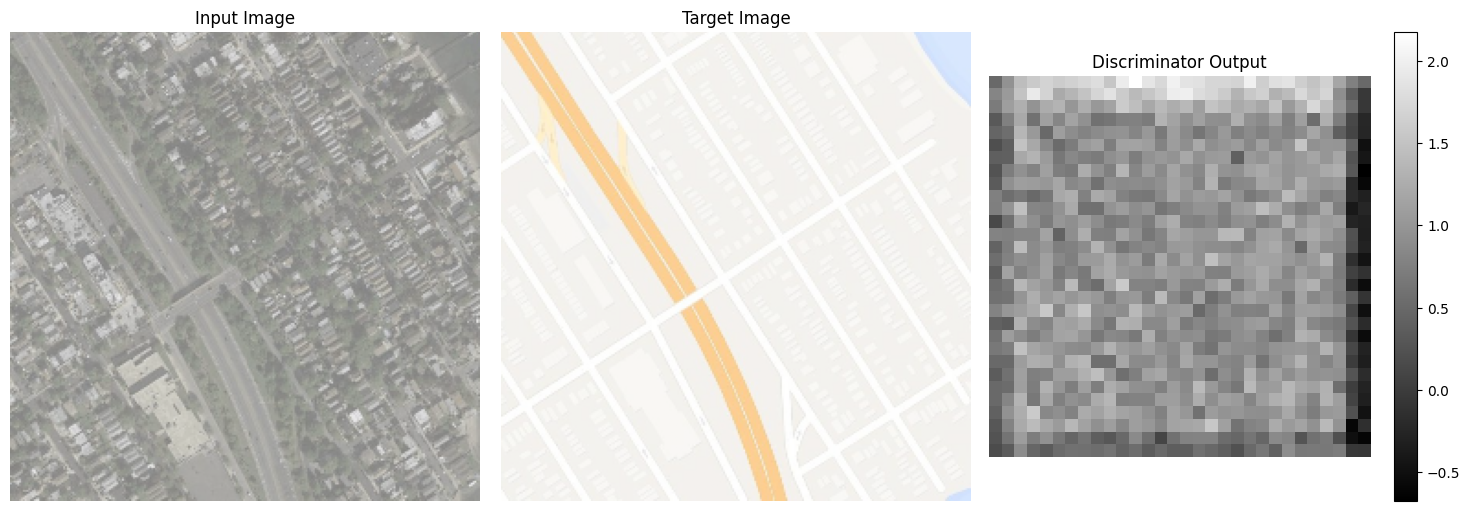

In [17]:
input_test = sample_images[0]
target_test = sample_masks[0]

input_test = tf.expand_dims(input_test, axis=0)
target_test = tf.expand_dims(target_test, axis=0)

discriminator_output = discriminator.model([input_test, target_test], training=False)[0]


input_test = (input_test[0] + 1) / 2
target_test = (target_test[0] + 1) / 2

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_test)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Target Image")
plt.imshow(target_test)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Discriminator Output")
plt.imshow(discriminator_output.numpy(), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()


# Loss Functions 


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, generated_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  generated_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)
  return real_loss + generated_loss

def generator_loss(generated_output, gen_output, target):
  adv_loss = cross_entropy(tf.ones_like(generated_output), generated_output)  # Fool the discriminator
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  return adv_loss + (100 * l1_loss)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [19]:
def display_samples(epoch, input_images, target_images, generated_images):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f'Epoch: {epoch + 1}')
    
    # Display the first image from the batch (index 0)
    axes[0].imshow(input_images[0])
    axes[1].imshow(target_images[0])
    axes[2].imshow(generated_images[0])
    
    # Set titles for each subplot
    axes[0].set_title("Input Image")
    axes[1].set_title("Target Image")
    axes[2].set_title("Generated Image")
    
    plt.show()


# Define training function

In [ ]:
# def update_disc_gen(input_image, target_image):
#   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

#     # generate an image based on input
#     generated_image = generator.model(input_image, training=True)

#     # discriminator outputs one for input and target and one for input and generated image
#     real_output = discriminator.model([input_image, target_image], training=True)
#     generated_output_disc = discriminator.model([input_image, generated_image], training=True)

#     # calculate the loss of thee generator and the discriminator
#     gen_loss = generator_loss(generated_output_disc, generated_image, target_image)
#     disc_loss = discriminator_loss(real_output, generated_output_disc)

#   # get gradient loss
#   gradients_of_generator = gen_tape.gradient(gen_loss, generator.model.trainable_variables)
#   gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.model.trainable_variables)

#   # apply the gradient loss to the variables
#   generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.model.trainable_variables))
#   discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.model.trainable_variables))

#   return gen_loss, disc_loss

# def train(data, epochs):
#   for epoch in range(epochs):
#     for input_image, target_image in data:
#       gen_loss, disc_loss = update_disc_gen(input_image, target_image)

#       print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

#       # print samples of training images
#       if ((epoch) % 10 == 0):
#         sample_image = generator.model(input_image, training=False)
#         display_samples(epoch, [input_image[0]], [target_image[0]], [sample_image[0]])

def update_disc_gen(input_image, target_image):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # generate an image based on input
    generated_image = generator(input_image, training=True)

    # discriminator outputs one for input and target and one for input and generated image
    real_output = discriminator([input_image, target_image], training=True)
    generated_output_disc = discriminator([input_image, generated_image], training=True)

    # calculate the loss of thee generator and the discriminator
    gen_loss = generator_loss(generated_output_disc, generated_image, target_image)
    disc_loss = discriminator_loss(real_output, generated_output_disc)

  # get gradient loss
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # apply the gradient loss to the variables
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

def train(data, epochs):
  for epoch in range(epochs):
    for input_image, target_image in data:
      gen_loss, disc_loss = update_disc_gen(input_image, target_image)

      print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")

      # print samples of training images
      if ((epoch) % 10 == 0):
        sample_image = generator(input_image, training=False)
        display_samples(epoch, [input_image[0]], [target_image[0]], [sample_image[0]])

In [21]:
# if you dont reassign data the world explodes
# i dont find this funny at all this took 3 hours to figure out
# why
data = (
    tf.data.Dataset.from_tensor_slices((images, masks))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
generator = load_model('Models\\maps\\second_generator_model_map.keras')
discriminator = load_model('Models\maps\second_discriminator_model_map.keras')

In [50]:
generator.save('pleasework_generator_model_maps.keras')
discriminator.save('pleasework_discriminator_model_maps.keras')

# Testing GAN with Validation set

In [27]:
def evaluate_gan(generator, discriminator, val_data):
  gen_loss = []
  disc_loss = []
  generated_images = []
  target_images = []

  for input_image, target_image in val_data.take(10):
    generated_image = generator(input_image, training=False)

    real_output = discriminator([input_image, target_image], training=False)
    generated_output_disc = discriminator([input_image, generated_image], training=False)

    cur_gen_loss = generator_loss(generated_output_disc, generated_image, target_image)
    cur_disc_loss = discriminator_loss(real_output, generated_output_disc)

    gen_loss.append(cur_gen_loss.numpy())
    disc_loss.append(cur_disc_loss.numpy())
    generated_images.append(generated_image)
    target_images.append(target_image)

  avg_gen_loss = np.mean(gen_loss)
  avg_disc_loss = np.mean(disc_loss)

  print(f"Validation Gen Loss: {avg_gen_loss}, Disc Loss: {avg_disc_loss}")

  return generated_images, target_images

In [28]:
dataset = load_data('Data\\maps\\val\\', trim=1000)
val_images, val_masks = dataset

val_data = (
  tf.data.Dataset.from_tensor_slices((val_images, val_masks))
  .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
  .shuffle(4000)
  .batch(32)
  .prefetch(tf.data.AUTOTUNE)
)

Data: 1000it [00:20, 47.76it/s]


In [54]:
maps_generator = load_model('F:\Pix2Pix-Image-Translation\Models\maps\\third_generator_model_maps.keras')
maps_discriminator = load_model('F:\Pix2Pix-Image-Translation\Models\maps\\third_discriminator_model_maps.keras')

In [57]:
generated_images, target_images = evaluate_gan(maps_generator, maps_discriminator, data)

Validation Gen Loss: 1.6366565227508545, Disc Loss: 1.3612797260284424


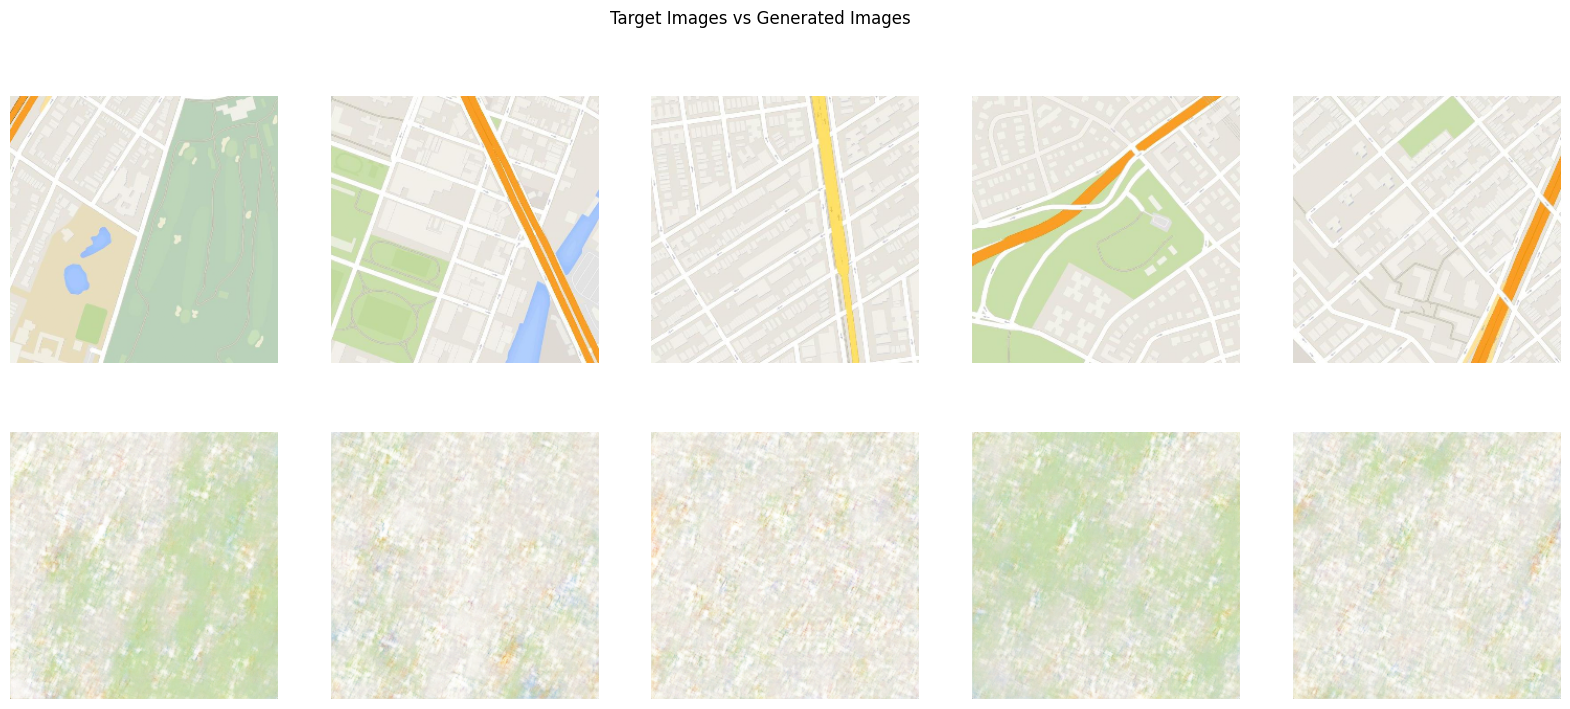

In [56]:
plt.figure(figsize=(20, 8))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    show_image(target_images[i][0])

    plt.subplot(2, 5, i + 6) 
    show_image(generated_images[i][0]) 
plt.suptitle('Target Images vs Generated Images')
plt.show()